# Multiclass classification with deep neural networks
This is deep neural network implementation from scratch, without using any machine learning libraries.

The dataset used is MNIST dataset of handwritten images.

## Table of Contents
- [1 - Load data](#1)
- [2 - Initialize Parameters](#2)
- [3 - Cost Function](#3)
- [4 - Activation Function](#4)
- [5 - Forward Propagation](#5)
- [6 - Backward Propagation](#6)
- [7 - Update Parameters](#7)
- [8 - Train Model](#8)
- [9 - Save and Load Model](#9)
- [10 - Predict](#10)
- [11 - Print Images](#11)

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import csv
from utils import * 

np.random.seed(1)

<a name='1'></a>
### Load data
Dataset contains training and test sets.
Each example is flattened `28x28` greyscale image of with shape `784 (28 * 28)`.

By default label set is a vector that contains single digit from `0` to `9`. 
In order to make it work first we need to expand this into a 10 dimensional matrix
e.g if the label is `4` we expand it to be `[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`
After this the label set shape will become `10 x 60000`

In [2]:
x_train, y_train_raw, x_test, y_test = load_mnist() # Load mnist dataset

m_train = x_train.shape[1] # Number of examples
num_px = x_train.shape[0] # Number of input elements
m_test = x_test.shape[1] # Number of test examples

# Normalize pixel values
x_train = x_train/255.
x_test = x_test/255.

# Expand Y values to vectors
# e.g. 4 will become [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
y_train = np.zeros((10, y_train_raw.shape[1]))
m = list(range(y_train_raw.shape[1]))
n = list(y_train_raw.squeeze())
y_train[n[:], m[:]] = 1

print ('Number of training examples: ', m_train)
print ('Number of testing examples:  ', m_test)
print ('------')
print ('Flattened image size:        ', num_px)
print ('------')
print ('x_train shape:               ', x_train.shape)
print ('y_train shape initial:       ', y_train_raw.shape)
print ('------')
print ('y_train shape expanded:      ', y_train.shape)
print ('------')
print ('x_test shape:                ', x_test.shape)
print ('y_test shape:                ', y_test.shape)

Number of training examples:  60000
Number of testing examples:   10000
------
Flattened image size:         784
------
x_train shape:                (784, 60000)
y_train shape initial:        (1, 60000)
------
y_train shape expanded:       (10, 60000)
------
x_test shape:                 (784, 10000)
y_test shape:                 (1, 10000)


## Functions 

<a name='2'></a>
### Initialize Parameters

In [3]:
def initialize_parameters(dims):
    """
    Initializes parameters
        Wl -- to random values
        bl -- to zeros
        
    Arguments:
        dims -- list of layer sizes
    
    Returns:
        parameters
            Wl -- weights matrix, shape (current layer nodes, previous layer nodes)
            bl -- biases vector, shape (current layer nodes, 1)
    """
    np.random.seed(1)
    parameters = {}
    L = len(dims) # Number of layers

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(dims[l], dims[l-1]) / np.sqrt(dims[l-1])
        parameters['b' + str(l)] = np.zeros((dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (dims[l], dims[l-1]))
        assert(parameters['b' + str(l)].shape == (dims[l], 1))
        
    return parameters

<a name='3'></a>
## Cost Function

Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{1}$$


In [4]:
def compute_cost(AL, Y):
    """
    Computes the cost

    Arguments:
        AL -- output vector(predictions), shape (number of classes, number of examples)
        Y -- actual values matrix, shape (number of classes, number of examples)

    Returns:
        cost -- cross-entropy cost
    """
    
    m = Y.shape[1]    
    n = Y.shape[0]
    cost = np.zeros((n, 1)) + 1
    
    for i in range(n):
        al = AL[i, :]
        y = Y[i, :]
        cost[i, :] = (1./m) * (-np.dot(y, np.log(al).T) - np.dot(1-y, np.log(1-al).T))
    
#     cost = (1./m) * (-np.dot(Y, np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)) 
#     cost = np.squeeze(cost)    

    
    return cost

<a name='4'></a>
### Activation Function

In this notebook, you will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$.



- **ReLU**: $A = RELU(Z) = max(0, Z)$. 


- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit.

- **`relu_backward`**: Implements the backward propagation for RELU unit.

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{2}$$  


In [5]:
def sigmoid(Z):
    """
    Calculates sigmoid of any input
    
    Arguments:
        Z -- numpy array of any shape
    
    Returns:
        A -- sigmoid of input Z, shape (same as Z)
        cache -- returns Z for caching, useful in backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Calculates RELU.

    Arguments:
        Z -- numpy array of any shape

    Returns:
        A -- Activation of Z
        cache -- returns Z for caching, useful in backpropagation
    """
    
    A = np.maximum(0,Z)
    
    assert A.shape == Z.shape, 'A should be same shape as Z'
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Calculates the backward propagation for a single RELU unit.

    Arguments:
        dA -- post-activation gradient, of any shape
        cache -- returns Z for caching, useful in backpropagation

    Returns:
        dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # convert dz to a numpy array.
    
    # When z <= 0, set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert dZ.shape == Z.shape, 'dZ should be the same shape as Z'
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Calculates the backward propagation for a single SIGMOID unit.

    Arguments:
        dA -- post-activation gradient, of any shape
        cache -- returns Z for caching, useful in backpropagation

    Returns:
        dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert dZ.shape == Z.shape, 'dZ should be the same shape as Z'
    
    return dZ

<a name='5'></a>
## Forward Propagation
Calculate forward propagation:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{3}$$
Followed by an activation.



In [6]:
def forward_pass(A_prev, W, b, activation):
    """
    Calculates activations of Z and passes to the next layer.
    
    Arguments:
        A_prev -- activations of previous layer
        W -- weight matrix of the current layer
        b -- bias values of the current layer
        activation -- type of activation function
    """
    activation = activation.lower()
    assert activation == 'relu' or activation == 'sigmoid', "activation should be either 'relu', or 'sigmoid'"
    
    Z = W.dot(A_prev) + b
    assert Z.shape == (W.shape[0], A_prev.shape[1]), 'wrong Z shape'

    linear_cache = (A_prev, W, b)   
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)    
    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    assert A.shape == (W.shape[0], A_prev.shape[1]), 'wrong A shape'
    
    cache = (linear_cache, activation_cache)

    return A, cache

In [7]:
def forward_propagate(X, parameters):
    """
    Propagates forward.
    
    Arguments:
        X -- numpy array of input data, shape (number of examples, input size)
        parameters -- initialized parameters
    
    Returns:
        AL -- output layer of predictions
        caches -- list of caches containing:
                    cache of relu activations
                    cache of sigmoid activation of output layer
    """

    caches = []
    A = X
    L = len(parameters) // 2 # number of layers
    
    for l in range(1, L):
        A_prev = A 
        A, cache = forward_pass(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)        
    
    AL, cache = forward_pass(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)

    assert AL.shape == (dims[len(dims) - 1],X.shape[1]), 'wrong output layer shape'

    return AL, caches

<a name='6'></a>
### Backward Propagation

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.


The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{4}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{5}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{6}$$

Pass parameters back by one layer

In [8]:
def backward_pass(dA, cache, activation):
    """
    Calculates derivative of activations and passes to the previous layer.
    
    Arguments:
        dA -- post-activation gradient of the current layer
        cache -- tuple of caches (linear_cache, activation_cache), saved during forward propagation
        activation -- name of activation function
    
    Returns:
        dA_prev -- Gradient of the cost with respect to the activation of the previous layer, same shape as A_prev
        dW -- Gradient of the cost with respect to W, same shape as W
        db -- Gradient of the cost with respect to b, same shape as b
    """
    linear_cache, activation_cache = cache
        
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]    
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

Backward propagate through all the layers

In [9]:
def backward_propagate(AL, Y, caches):
    """
    Propagates backwards
    
    Arguments:
        AL -- output layer predictions
        Y -- actual values
        caches -- list of caches containing:
                    cache of relu activations
                    cache of sigmoid activations of the last layer
    
    Returns:
        grads -- A dictionary of gradients 'dA', 'dW', 'db'

    """
    grads = {}
    L = len(caches) # number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Initialize the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = backward_pass(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = backward_pass(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

<a name='7'></a>
### Update Parameters

Update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{8}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{9}$$

where $\alpha$ is the learning rate. 

After computing the updated parameters, store them in the parameters dictionary. 

In [10]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters.
    
    Arguments:
        parameters -- dictionary of parameters 
        grads -- dictionary of gradients
    
    Returns:
        parameters -- dictionary of updated parameters 'W' and 'b'
    """
    
    L = len(parameters) // 2 # number of layers

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

<a name='8'></a>
### Train Model

User above defined functions to train a model

In [11]:
def model(X, Y, dims, learning_rate = 0.01, epochs = 100, print_cost=False):
    """
    Trains full deep neural network.
    
    Arguments:
        X -- numpy array of input data, shape (flattened image pixel number, number of examples)
        Y -- actual values
        layers_dims -- list of layers
        learning_rate -- learning rate
        epochs -- number of iterations
        print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
        parameters -- learned parameters.
    """

    costs = []

    parameters = initialize_parameters(dims)
        
    # Gradient descent
    for i in range(0, epochs):

        AL, caches = forward_propagate(X, parameters)
        
        cost = compute_cost(AL, Y)

        grads = backward_propagate(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == epochs - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == epochs:
            costs.append(cost)
    
    return parameters, costs

In [12]:
input_layer = x_train.shape[0] # set input layer size
dims = [input_layer, 128, 128, 10] # set layer number and sizes

# parameters, costs = model(x_train[:, :10000], y_train[:, :10000], dims, learning_rate=0.0075, epochs = 100, print_cost = True)
parameters, costs = model(x_train, y_train, dims, learning_rate=0.0075, epochs = 2500, print_cost = True)

Cost after iteration 0: [0.70142882 0.76044444 0.63946462 0.69396326 0.6670153  0.6770334
 0.67782827 0.64068001 0.67950968 0.79784079]
Cost after iteration 100: [0.31605666 0.29147598 0.33551197 0.342628   0.30701763 0.29902622
 0.32461938 0.31418076 0.36498056 0.33963148]
Cost after iteration 200: [0.25742714 0.27483235 0.31060692 0.32141799 0.27738903 0.28791111
 0.30715214 0.2818912  0.35436543 0.32388542]
Cost after iteration 300: [0.18707768 0.23999375 0.27926415 0.28888798 0.23764823 0.27377348
 0.28176694 0.23170926 0.34128323 0.29773221]
Cost after iteration 400: [0.13579453 0.18893308 0.24234842 0.24856974 0.19640012 0.25422108
 0.24433614 0.17882303 0.32519127 0.26549118]
Cost after iteration 500: [0.10728432 0.1413124  0.20704532 0.21105611 0.16624901 0.23202257
 0.196418   0.14199014 0.30702334 0.24178974]
Cost after iteration 600: [0.09003888 0.10896511 0.17799246 0.18140251 0.14624879 0.21182066
 0.15102677 0.11916893 0.28534504 0.22686139]
Cost after iteration 700: [0.0

<a name='9'></a>
## Save and Load Model

Save model to csv files for later use

In [13]:
def save_model(parameters):
    path = './model/'
    f = open(path + 'param_keys.csv', 'w')
    w = csv.writer(f, delimiter=',')
    keys = list(parameters.keys())
    w.writerow(keys)
    f.close()
    
    for key in keys:        
        np.savetxt(path + key + '.csv', parameters[key], delimiter=",")        
        
def load_model():
    path = './model/'
    parameters = {}
    param_keys = []
    with open(path + 'param_keys.csv', newline='') as csvfile:
        content = csv.reader(csvfile, delimiter=',', quotechar='|')            
        for row in content:
            if len(row):
                param_keys = list(row)
    for key in param_keys:
        p = np.genfromtxt(path + key + '.csv', delimiter=',')
        parameters[key] = p.reshape(p.shape[0], -1)
    return parameters

In [14]:
save_model(parameters)
parameters = load_model()

<a name='10'></a>
## Predict

Use forward propagation to make predictions

In [15]:
def predict(X, y, parameters):
    """
    Predicts using learned parameters.
    
    Arguments:
        X -- input data
        parameters -- parameters of the prevously trained model
        
    Returns:
        right_preds -- dictionary of the right predictions
        wrong_preds -- dictionary of the wrong predictions
        low_confidence_preds -- dictionary of the predictions with low confidence
    """
    
    m = X.shape[1] # number of examples
    sum_rights = 0 # number of correct predictions
    
    predictions = {
        "right": {},
        "wrong": {},
        "low_confidence": {}
    }

    # Forward propagation
    preds, caches = forward_propagate(X, parameters)

    for i in range(preds.shape[1]):
        max_pred = preds[:, i]
        prediction = np.argmax(max_pred, axis=None)
        actual = y[:, i].squeeze()
        
        if max(max_pred) < 0.1: 
            predictions['low_confidence'][i] = {
                'pred': prediction,
                'actual': int(actual),
                'confidence': preds[prediction, i]
            }
        elif prediction == actual:
            sum_rights += 1
            predictions['right'][i] = {
                'pred': prediction,
                'actual': int(actual),
                'confidence': preds[prediction, i]
            }
        else:
            predictions['wrong'][i] = {
                'pred': prediction,
                'actual': int(actual),
                'confidence': preds[prediction, i]
            }

    accuracy = sum_rights/m
    
    return accuracy, predictions

In [17]:
accuracy, predictions = predict(x_test, y_test, parameters)
print('accuracy:       ', accuracy)
print('correct:        ', len(predictions['right']))
print('mistakes:       ', len(predictions['wrong']))
print('low confidence: ', len(predictions['low_confidence']))

accuracy:        0.9069
correct:         9069
mistakes:        883
low confidence:  48


<hr>

#### Print predictions

In [18]:
print_num = 10
num = 0

for i in predictions['low_confidence']:
    print(i, predictions['low_confidence'][i])
    if num > print_num:
        break
    num += 1

66 {'pred': 2, 'actual': 6, 'confidence': 0.09720772600947349}
97 {'pred': 7, 'actual': 7, 'confidence': 0.05722972289868852}
495 {'pred': 0, 'actual': 8, 'confidence': 0.05098865102802033}
514 {'pred': 6, 'actual': 6, 'confidence': 0.0223158585499284}
552 {'pred': 0, 'actual': 0, 'confidence': 0.07597712125726902}
659 {'pred': 9, 'actual': 2, 'confidence': 0.07938259569166886}
992 {'pred': 9, 'actual': 9, 'confidence': 0.08367031377019608}
998 {'pred': 8, 'actual': 8, 'confidence': 0.046734030735870714}
1101 {'pred': 2, 'actual': 8, 'confidence': 0.08134865051168073}
1128 {'pred': 3, 'actual': 3, 'confidence': 0.03096905313235712}
1444 {'pred': 0, 'actual': 6, 'confidence': 0.07549845788451195}
1678 {'pred': 0, 'actual': 2, 'confidence': 0.030116186142989592}


<a name='11'></a>
### Print Images
print images in predictions dictionary

In [19]:
def print_images(X, p, num_images=10):
    """
    Plots images where predictions and truth were different.
        X -- dataset
        y -- true labels
        p -- predictions
    """
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    plt_num = 1
    row = 1
    for index in p:
        plt.subplot(1, num_images, plt_num)
        plt.imshow(X[:, index].reshape(28,28), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + str(p[index]['pred']) + " \n Actual: " + str(p[index]['actual']))
        
        plt_num += 1
        if plt_num % 10 == 0: 
            row+= 1
        if plt_num >= num_images:
            break

Print wrongly predicted images

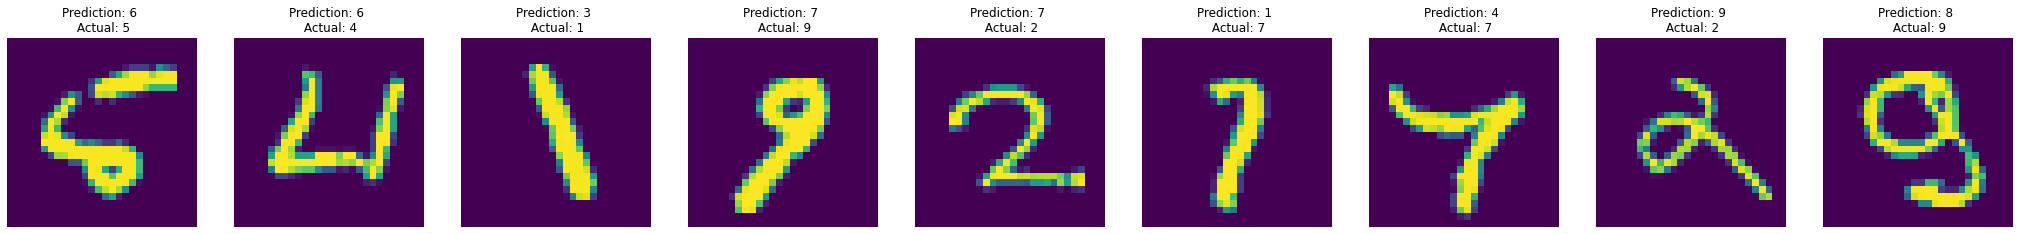

In [20]:
print_images(x_test, predictions['wrong'])